In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import time

import sys
import glob
from PIL import Image
import pickle
import os
import queue
from skimage import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from joblib import Parallel, delayed
import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


In [2]:
n_media       = 1.512               # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.9                 # illumination NA of the condenser
N_defocus     = 7                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 0.5               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-N_defocus//2)*z_step
chi           = 0.03*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/gpfs/CompMicro/Hummingbird/RawData/Interns/7_17_19_U2OS_Thinchamber/U2OS untreated chamber_3/' # data path
bg_path       = '/gpfs/CompMicro/Hummingbird/RawData/Interns/2019_07_22_U2OS_6well/Empty_Background/Pos0/'# background data path
output_path   = '/gpfs/CompMicro/Projects/nucleolus/labelfree_segmentation/phase_recon/7_17_19_thinchamber_hulk/'# output image path
use_gpu = True

In [3]:
data_paths = sorted(glob.glob(data_path + "/*/"))
N_Pos = len(data_paths)
Nimg = N_defocus*N_channel

In [4]:
output_paths = [output_path + "Pos" + str(i) + "/" for i in range(N_Pos)]

In [5]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    lambda_u = 1e-2   # absorption regularizer
    lambda_p = 1e-2   # phase regularizer
    rho = 2.5         # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 10          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [16]:
# Plot setting

max_phase = 1.5                    # maximum phase value to display
min_phase = -0.5                     # minimum phase value to display

max_ret   = 2.5e-3/lambda_illu*2*np.pi # maximum retardance value
all_z     = False                    # plot all z birefringence or not
z_layer   = 3                        # focal layer to plot if only plot single layer
recon_birefringence = False           # Reconstruct birefringence?
recon_phase = True                  # Reconstruct phase?
lambdas = np.linspace(1e-2,1e-4, num = 10)

In [7]:
files = {}
for i in np.arange(N_Pos):
    files[i] = sorted(glob.glob(data_paths[i] + '*0[0-5][0-9]_state*.tif'))

In [8]:
filedir_bg = bg_path + '*Acquired*.tif'
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

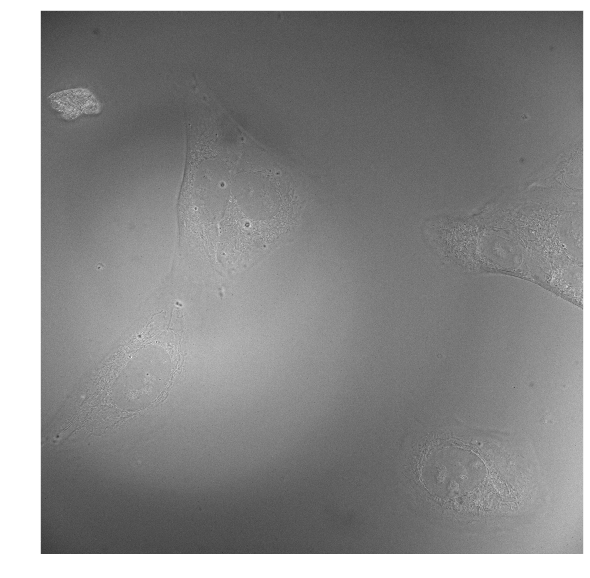

In [9]:
# select a FOV for processing

# Ns = 600
# Ms = 600
# n_start = [550, 1400] 

Ns = 2048
Ms = 2048
n_start = [0, 0] 


plt.figure(figsize=(10,10))
plt.imshow(io.imread(files[1][2]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms], cmap = 'gray')


In [10]:
setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option)

In [11]:
os.system('mkdir ' + output_path)
for path in output_paths:
    os.system('mkdir '+path)
    os.system('mkdir '+path+'phase')
    os.system('mkdir '+path+'birefringence')

In [12]:
# Helper function for testing lambda_p
def phase_recon_test(setup, files, files_bg, Nimg, lambdas):
    """Use this helper function to """

    # Load background images
    Nbg = len(files_bg)
    I_bg_pre = []

    for i in range(0, Nbg):
        Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms] + 1
        I_bg_pre.append(Itemp)

    I_bg_pre = np.array(I_bg_pre)

    I_bg = np.zeros_like(I_bg_pre)
    I_bg = wo.intensity_mapping(I_bg_pre)

    m = 0
    # Load Polscope images
    I_meas_pre =[]

    for i in range(0, Nimg):
        Itemp = io.imread(files[1][m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
        I_meas_pre.append(Itemp)
        sys.stdout.write("\r" + "Loaded Polscope image " + str(i))
        sys.stdout.flush()
    I_meas_pre = np.array(I_meas_pre)
    I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

    # intensity mapping to match the theory
    I_meas = np.zeros_like(I_meas_pre)
    for i in range(N_defocus):
        I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])
        sys.stdout.write("\r" + "Intensity mapping " + str(i))
        sys.stdout.flush()
    
    print("\n")
    # Stokes vector recon with bg correction
    S_image_recon = setup.Stokes_recon(I_meas)
    S_bg_recon = setup.Stokes_recon(I_bg)
    S_image_tm = setup.Stokes_transform(S_image_recon,use_gpu=use_gpu)
    S_bg_tm = setup.Stokes_transform(S_bg_recon,use_gpu=use_gpu)
    S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm, use_gpu=use_gpu)  
    Recon_para = setup.Polarization_recon(S_image_tm,use_gpu=use_gpu)


    # Take out S0 for phase reconstruction
    S0_stack = S_image_tm[0].copy()

    phase_imgs = []
    for p in lambdas:
        print("Test " + str(p))
        if deconv == 'Tikhonov':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = p, use_gpu=use_gpu)

        elif deconv =='TV':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = p, \
                                                  itr = itr, rho=rho, verbose = verbose, use_gpu=use_gpu)
        #file_name_phase = output_path+'phase/'+raw_imgs[m].split('state')[0].rsplit('/')[-1]+str(mu)+'phase.tiff'
        phase_imgs.append(phi_sample)

    phase_imgs = np.array(phase_imgs)
    return phase_imgs

In [13]:
test = phase_recon_test(setup, files, files_bg, Nimg, lambdas)

Intensity mapping 6ge 34

Test 0.01
Test 0.0089
Test 0.0078
Test 0.0067
Test 0.0056
Test 0.0045
Test 0.0034000000000000002
Test 0.0023
Test 0.0011999999999999997
Test 0.0001


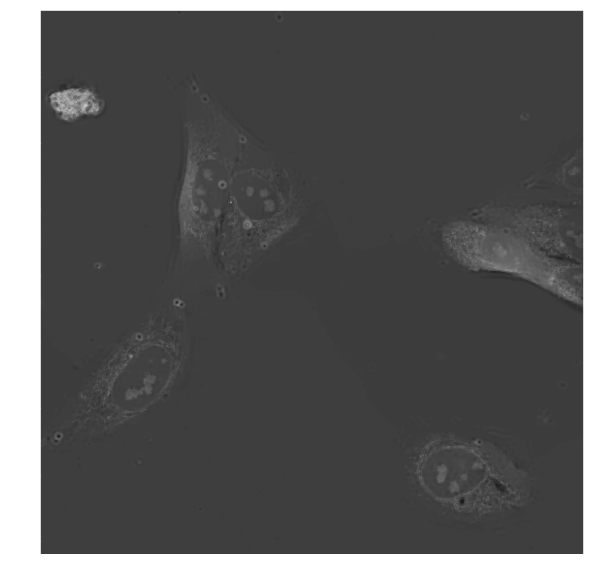

In [15]:
# Choose to stick with 1e-2, with the following vmin and vmax
plt.figure(figsize = (10,10))
plt.imshow(test[0], vmin = -0.5, vmax = 1.5, cmap = 'gray')

In [17]:
#Helper function for parallelization
def recon_phase_pos(pos, gpu_id):
    for m in range(N_time):
        # Load Polscope images
        I_meas_pre =[]

        for i in range(0, Nimg):
            Itemp = io.imread(files[pos][m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
            I_meas_pre.append(Itemp)
        I_meas_pre = np.array(I_meas_pre)
        I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

        # intensity mapping to match the theory
        I_meas = np.zeros_like(I_meas_pre)
        for i in range(N_defocus):
            I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])


        # Stokes vector recon with bg correction
        S_image_recon = setup.Stokes_recon(I_meas)
        S_bg_recon = setup.Stokes_recon(I_bg)
        S_image_tm = setup.Stokes_transform(S_image_recon,use_gpu=use_gpu, gpu_id = gpu_id)
        S_bg_tm = setup.Stokes_transform(S_bg_recon,use_gpu=use_gpu, gpu_id = gpu_id)
        S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm, use_gpu=use_gpu, gpu_id = gpu_id) 
        Recon_para = setup.Polarization_recon(S_image_tm,use_gpu=use_gpu, gpu_id = gpu_id)



        # Take out S0 for phase reconstruction
        S0_stack = S_image_tm[0].copy()


        # Phase reconstruction

        if deconv == 'Tikhonov':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p, use_gpu=use_gpu, gpu_id = gpu_id)

        elif deconv == 'TV':
            mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, \
                                                      itr = itr, rho=rho, verbose = verbose, use_gpu=use_gpu, gpu_id = gpu_id)


        # figure plotting as tiff files\
        file_name_phase = output_paths[pos]+'phase/'+files[pos][m*Nimg].split('state')[0].rsplit('/')[-1]+'phase.tiff'
        plt.imsave(file_name_phase, phi_sample, format="tiff", cmap=plt.cm.gray, vmin=min_phase, vmax=max_phase)

        if all_z == True:
            for i in range(N_defocus):

                bi_hsv = np.transpose(np.array([Recon_para[1,:,:,i]/np.pi, \
                                                   np.ones((Ns,Ms)), \
                                                   np.clip(Recon_para[0,:,:,i]/max_ret,0,1)]), (1,2,0))
                bi_rgb = hsv_to_rgb(bi_hsv.copy())

                file_name_bire = output_path[pos]+'birefringence/'+files[pos][m*Nimg+i].split('state0')[0].split('/')[1]\
                                    +files[pos][m*Nimg+i].split('state0')[1].split('.')[0]+'_birefringence.tiff'
                plt.imsave(file_name_bire, bi_rgb, format="tiff")

        elif recon_birefringence == True:
                bi_hsv_1 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                                   np.ones((Ns,Ms)), \
                                                   np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1)]), (1,2,0))
                norm_phase = np.clip(phi_sample, min_phase, max_phase)-min_phase
                norm_phase /= np.max(norm_phase)
                bi_hsv_2 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                                   np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1), \
                                                   norm_phase]), (1,2,0))
                bi_rgb_temp = hsv_to_rgb(bi_hsv_1.copy())
                bi_rgb_1 = bi_rgb_temp.copy()


                bi_rgb_temp = hsv_to_rgb(bi_hsv_2.copy())
                bi_rgb_2 = bi_rgb_temp.copy()


                file_name_bire = output_path[pos]+'birefringence/'+files[m*Nimg+z_layer].split('state0')[0].rsplit('/')[-1]\
                                        +files[pos][m*Nimg+z_layer].split('state0')[1].split('.')[0]+'_birefringence.tiff'
                plt.imsave(file_name_bire, bi_rgb, format="tiff")



        print('Number of image stacks processed (%d / %d)'%(m+1,N_time))

# Parallelize Positions

## 1) Assigning all positions to one GPU, with threads.

In [18]:
init_time = time.time()

Nimg = N_defocus*N_channel
N_time = len(files[0])//Nimg

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms] + 1
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

N_GPU = 4

# Put indices in queue
q = queue.Queue(maxsize=N_GPU)
for i in range(N_GPU):
    q.put(i)

def phase_helper(pos):
    gpu = q.get()
    
    #Function using gpu, but just use the first GPU
    recon_phase_pos(pos, 0)

    # return gpu id to queue
    q.put(gpu)

# Change loop
Parallel(n_jobs=5, prefer = "threads",verbose = 10)(delayed(phase_helper)(i) for i in range(N_Pos))
#Parallel(n_jobs = 5, verbose = 10)(delayed(recon_phase_pos)(pos) for pos in range(N_Pos))

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


Number of image stacks processed (1 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (

Number of image stacks processed (50 / 60)
Number of image stacks processed (49 / 60)
Number of image stacks processed (48 / 60)
Number of image stacks processed (49 / 60)
Number of image stacks processed (50 / 60)
Number of image stacks processed (51 / 60)
Number of image stacks processed (49 / 60)
Number of image stacks processed (50 / 60)
Number of image stacks processed (51 / 60)
Number of image stacks processed (52 / 60)
Number of image stacks processed (50 / 60)
Number of image stacks processed (51 / 60)
Number of image stacks processed (52 / 60)
Number of image stacks processed (53 / 60)
Number of image stacks processed (51 / 60)
Number of image stacks processed (52 / 60)
Number of image stacks processed (53 / 60)
Number of image stacks processed (52 / 60)
Number of image stacks processed (54 / 60)
Number of image stacks processed (53 / 60)
Number of image stacks processed (54 / 60)
Number of image stacks processed (53 / 60)
Number of image stacks processed (55 / 60)
Number of i

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  8.8min remaining: 13.1min


Number of image stacks processed (60 / 60)


[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  8.8min remaining:  5.9min


Number of image stacks processed (60 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (7 / 60)
Number of image stacks processed (8 / 60)
Number of image stacks processed (9 / 60)
Number of image stacks processed (10 / 60)
Number of image stacks processed (11 / 60)
Number of image stacks processed (12 / 60)
Number of image stacks processed (13 / 60)
Number of image stacks processed (14 / 60)
Number of image stacks processed (15 / 60)
Number of image stacks processed (16 / 60)
Number of image stacks processed (17 / 60)
Number of image stacks processed (18 / 60)
Number of image stacks processed (19 / 60)
Number of image stacks processed (20 / 60)
Number of image stacks processed (21 / 60)
Number of image stacks processed (22 / 60)
Number of image stac

[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 14.9min finished


[None, None, None, None, None]

## 2) Assigning each position to an available GPU. Out of memory.

In [21]:
init_time = time.time()

Nimg = N_defocus*N_channel
N_time = len(files[0])//Nimg

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms] + 1
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

N_GPU = 4

# Put indices in queue
q = queue.Queue(maxsize=N_GPU)
for i in range(N_GPU):
    q.put(i)

def phase_helper(pos):
    gpu = q.get()

    #Function using gpu
    recon_phase_pos(pos, gpu)

    # return gpu id to queue
    q.put(gpu)

# Change loop
Parallel(n_jobs=N_GPU, prefer = "threads",verbose = 10)(delayed(phase_helper)(i) for i in range(N_Pos))
#Parallel(n_jobs = 5, verbose = 10)(delayed(recon_phase_pos)(pos) for pos in range(N_Pos))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Number of image stacks processed (1 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (1 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (2 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (7 / 60)
Number of image stacks processed (7 / 60)
Number of image stacks processed (7 / 60)
Number of image stacks processed (8 / 60)
Number of image stacks processed (

[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  7.3min remaining: 10.9min


OutOfMemoryError: out of memory to allocate 268435456 bytes (total 5301600256 bytes)

Number of image stacks processed (2 / 60)
Number of image stacks processed (60 / 60)
Number of image stacks processed (3 / 60)
Number of image stacks processed (4 / 60)
Number of image stacks processed (5 / 60)
Number of image stacks processed (6 / 60)
Number of image stacks processed (7 / 60)
Number of image stacks processed (8 / 60)
Number of image stacks processed (9 / 60)
Number of image stacks processed (10 / 60)
Number of image stacks processed (11 / 60)
Number of image stacks processed (12 / 60)
Number of image stacks processed (13 / 60)
Number of image stacks processed (14 / 60)
Number of image stacks processed (15 / 60)
Number of image stacks processed (16 / 60)
Number of image stacks processed (17 / 60)
Number of image stacks processed (18 / 60)
Number of image stacks processed (19 / 60)
Number of image stacks processed (20 / 60)
Number of image stacks processed (21 / 60)


> Assigning each position to an available GPU runs into a out of memory error.